In [113]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [114]:
def f(x):
  return 3*x**2 +4*x+5

In [115]:
f(5)

100

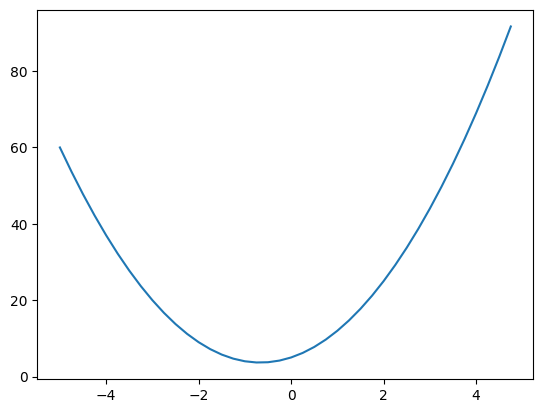

In [116]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [117]:
#basic derivative
h = 0.000001
x = 1/3
f_prime = (f(x+h)-f(x))/h
print(f_prime)


6.000003000217191


In [118]:
#getting more variables
a = 4.0
b = -3.0
c = 12.0
d1 = a*b+c
#a += h
#b += h
c+= h
d2 = a*b+c
f_prime = (d2-d1)/h
print(f_prime)

0.9999999992515995


In [119]:
class Value:
  def __init__(self, data):
    self.data = data
  def __repr__(self):
    return f"Value(data = {self.data})"

a = Value(2.0)
b = Value(-3.0)
"""a+b
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-23-c3c185279d03> in <cell line: 9>()
      7 a = Value(2.0)
      8 b = Value(-3.0)
----> 9 a+b

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'"""


"a+b\n---------------------------------------------------------------------------\nTypeError                                 Traceback (most recent call last)\n<ipython-input-23-c3c185279d03> in <cell line: 9>()\n      7 a = Value(2.0)\n      8 b = Value(-3.0)\n----> 9 a+b\n\nTypeError: unsupported operand type(s) for +: 'Value' and 'Value'"

In [120]:
class Value:
  def __init__(self, data, _children = (), _op = '', label = ''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data = {self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
        self.grad += 1.0 * out.grad
        other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __rsub__(self, other):
    return other + (-self)

  def __radd__(self, other):
    return self + other

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other ** -1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
        self.grad = (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')
    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad = out.data * out.grad
    out.backward = _backward
    return out

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
#a.__add__(b)
a+b
#a.__mul__(b).__mul__(c)
e = a*b
e.label = 'e'
d = e*c
d.label = 'd'

In [121]:
a = Value(2.0)
a-2

Value(data = 0.0)

In [122]:
d._prev

{Value(data = -6.0), Value(data = 10.0)}

In [123]:
d._op

'*'

In [124]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s| data %.4f | grad %.4f}" % (n.label, n.data, n.grad ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

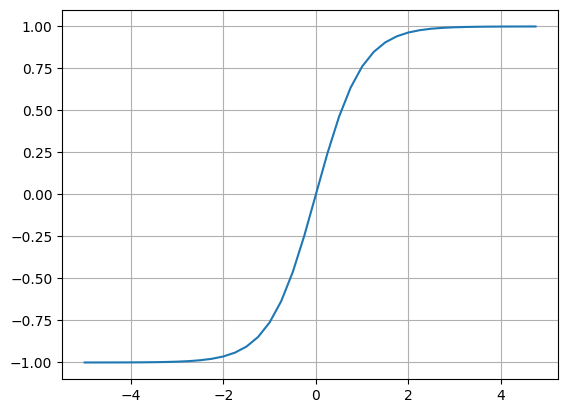

In [125]:
plt.plot(np.arange(-5,5,0.25), np.tanh(np.arange(-5,5,0.25)))
plt.grid()

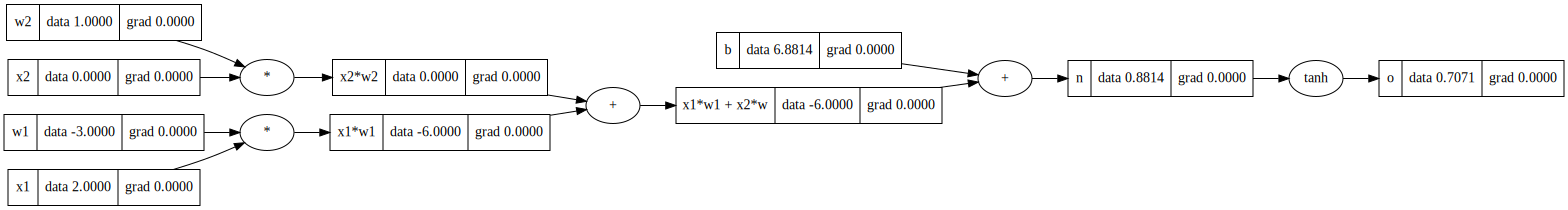

In [126]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.8813735870195432, label = 'b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [127]:
o.backward()

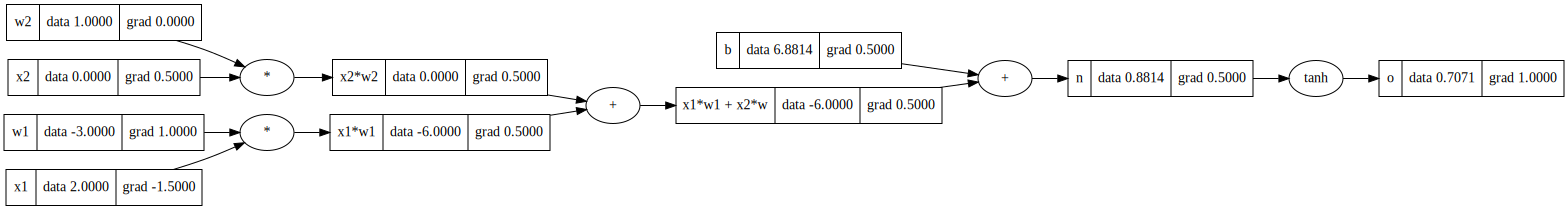

In [128]:
draw_dot(o)

In [129]:
a = Value(2.0)
3+a

Value(data = 5.0)

In [130]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(np.random.uniform(-1,1))
  def parameters(self):
    return self.w + [self.b]

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x


In [131]:
x = [2.0, 3.0, -1.0]
n = Layer(3, 4)
n(x)

[Value(data = 0.9001319862523577),
 Value(data = -0.9410462371776231),
 Value(data = -0.9954936173027557),
 Value(data = 0.9961352300558558)]

In [132]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = 0.8245386593781228)

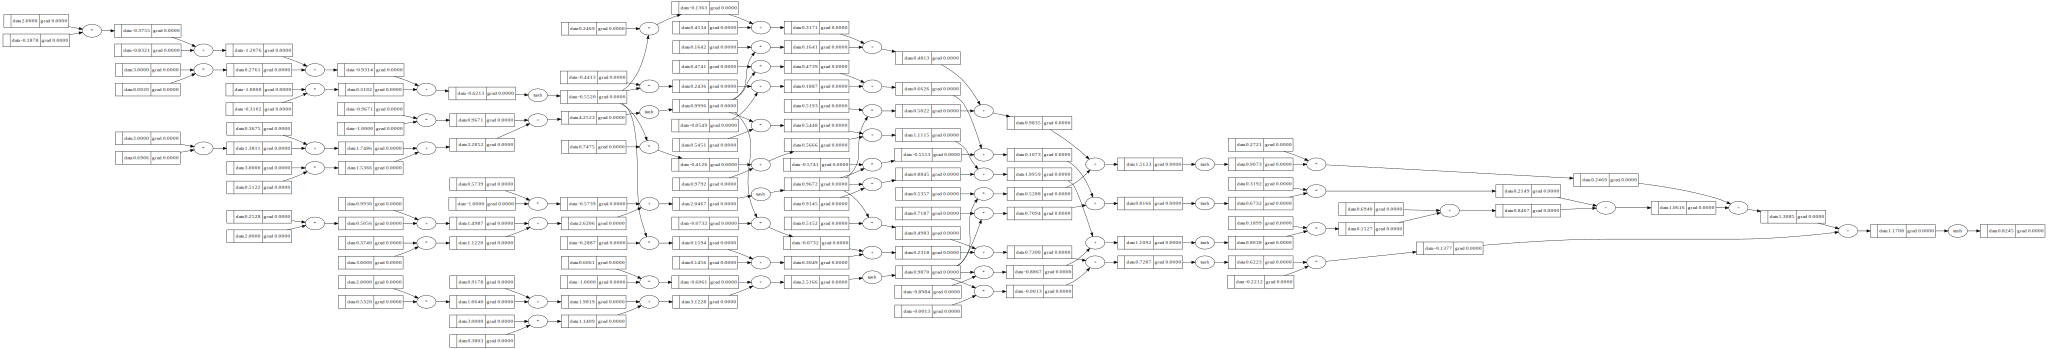

In [133]:
draw_dot(n(x))

In [134]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [135]:
ypred = [n(x) for x in xs]
ypred

[Value(data = 0.8245386593781228),
 Value(data = 0.8143020542384533),
 Value(data = 0.7740250108120991),
 Value(data = 0.8245099550598977)]

In [136]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data = 6.500440120926647)

In [137]:
loss.backward()

In [138]:
n.layers[0].neurons[0].w[0]

Value(data = -0.1877514724019278)

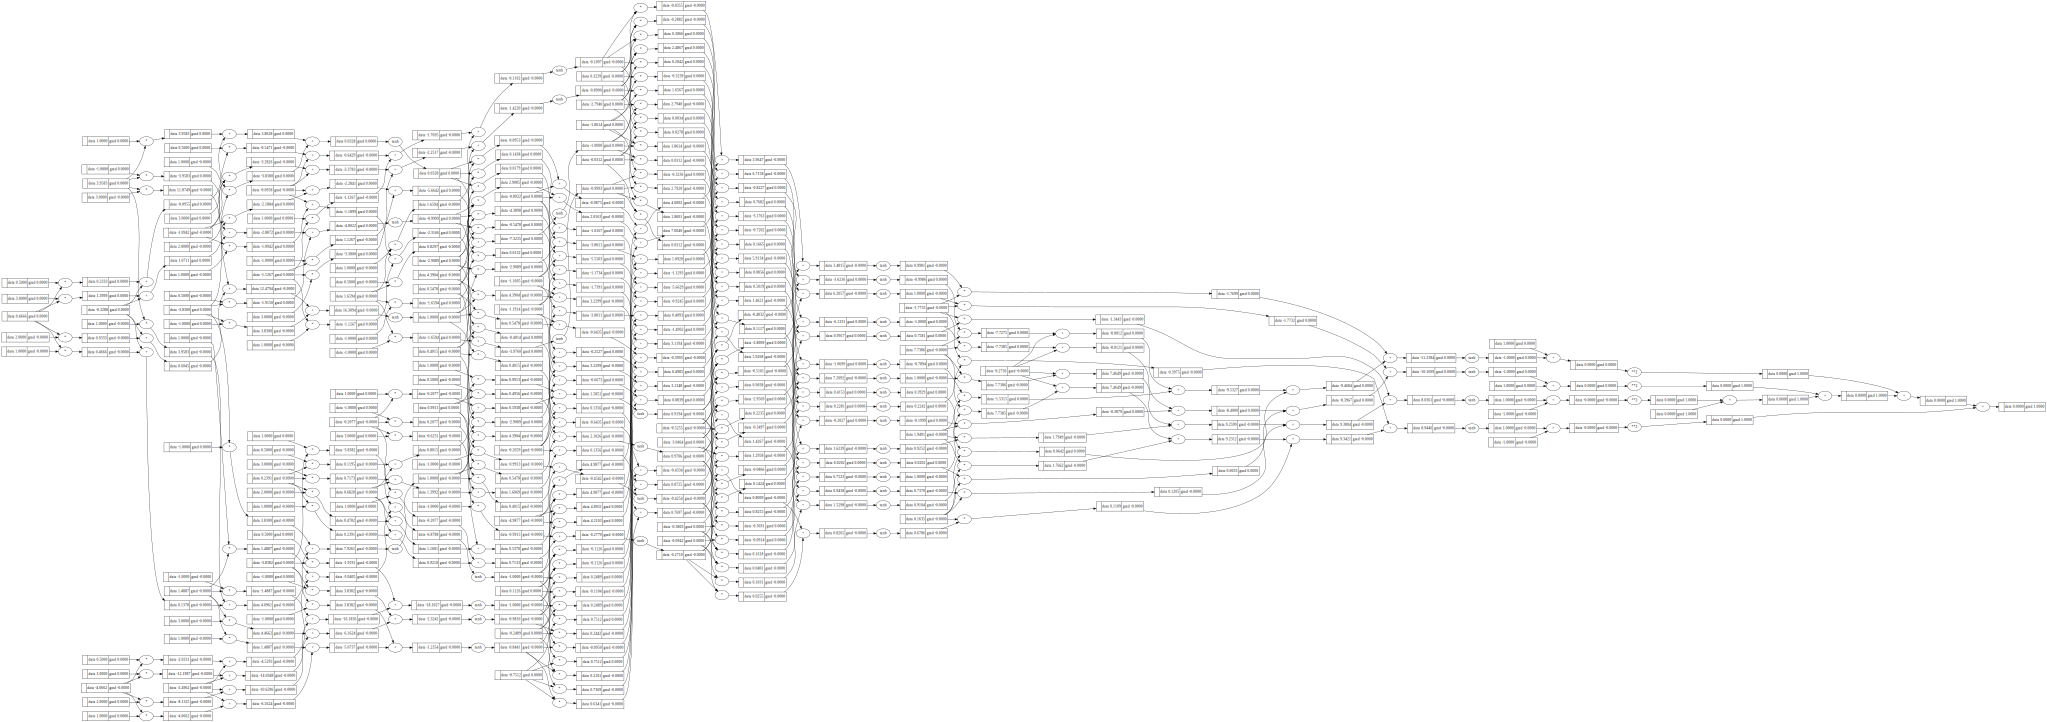

In [182]:
draw_dot(loss)

In [140]:
len(n.parameters())

41

In [179]:
for i in range(20):
  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  for p in n.parameters():
    p.data += -0.01* p.grad
  print(i, loss.data)


0 4.5015172760741054e-14
1 4.5015172760741054e-14
2 4.5015172760741054e-14
3 4.5015172760741054e-14
4 4.5015172760741054e-14
5 4.5015172760741054e-14
6 4.5015172760741054e-14
7 4.5015172760741054e-14
8 4.5015172760741054e-14
9 4.5015172760741054e-14
10 4.5015172760741054e-14
11 4.5015172760741054e-14
12 4.5015172760741054e-14
13 4.5015172760741054e-14
14 4.5015172760741054e-14
15 4.5015172760741054e-14
16 4.5015172760741054e-14
17 4.5015172760741054e-14
18 4.5015172760741054e-14
19 4.5015172760741054e-14


In [181]:
ypred

[Value(data = 0.9999997906000991),
 Value(data = -0.9999999970654212),
 Value(data = -0.9999999996536438),
 Value(data = 0.9999999659688001)]

In [180]:
n.layers[0].neurons[0].w[0].data

0.4666462826739785